In [1]:
import mne
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from colour import Color
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from matplotlib.gridspec import GridSpec
import pyprep
from scipy import stats
from scipy.stats import zscore
import pandas as pd
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs

plt.rcParams["font.family"] = "Arial"
mne.__version__

'1.3.1'

In [2]:
n_part = 29 # number of participants

In [3]:
def get_stat(var): # get median and 25th, 75th percentiles
    print(f'{np.median(var):.2f} [{np.percentile(var, 25):.2f}-{np.percentile(var, 75):.2f}]')

In [5]:
fs = 500
electrodes = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T3', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T4', 'TP9', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP10', 'T5', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'T6', 'PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2']

dict_rows = {
    'Fp':0,
    'F':1,
    'FC':2,
    'T':-1,
    'TP':-1,
    'C':3,
    'CP':4,
    'P':5,
    'PO':6,
    'O':7,
}

dict_cols = {
    '9':-1,
    '7':0,
    '5':1,
    '3':2,
    '1':3,
    'z':4,
    '2':5,
    '4':6,
    '6':7,
    '8':8, 
    '10':-1
}

cols_seq = [dict_cols[re.split('(\d+)', i)[1]] if 'z' not in i else dict_cols[i[-1]] for i in electrodes]
rows_seq = [dict_rows[re.split('(\d+)', i)[0]] if 'z' not in i else dict_rows[i[:-1]] for i in electrodes]

cols_seq[electrodes.index('T3')] = 0
rows_seq[electrodes.index('T3')] = 3
cols_seq[electrodes.index('T4')] = 8
rows_seq[electrodes.index('T4')] = 3

cols_seq[electrodes.index('T5')] = 0
rows_seq[electrodes.index('T5')] = 5
cols_seq[electrodes.index('T6')] = 8
rows_seq[electrodes.index('T6')] = 5

nrows = max(rows_seq)+1
ncols = max(cols_seq)+1

figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25), sharex=True, sharey=True, dpi=200)

for e in range(len(electrodes)):
    if electrodes[e] in ['TP9', 'TP10']:
        continue
    axes[rows_seq[e]][cols_seq[e]].set_title(electrodes[e], fontsize=18, fontweight='bold')
    
pairs = [str(rows_seq[i])+str(cols_seq[i]) for i in range(len(electrodes))]
    
for row in range(nrows):
    for col in range(ncols):
        if str(row) + str(col) not in pairs:
            axes[row][col].set_axis_off()

# figure.subplots_adjust(right=0.8)
# cbar_ax = figure.add_axes([0.83, 0.4, 0.01, 0.3])
# cbar = figure.colorbar(cp, cax=cbar_ax)
# cbar.ax.set_title(mode, fontsize=18)
            
plt.suptitle('Smth', fontsize=32, y=0.95, fontweight='bold')
plt.show()

# ERP

In [25]:
rest_erp = np.load('preprocesed_data/erp/rest.npy')
im_erp = np.load('preprocesed_data/erp/imagery.npy')

In [26]:
es_p100_left = [
    electrodes.index(i) for i in ['P1', 'CP3', 'P5', 'P3']
]
es_p100_right = [
    electrodes.index(i) for i in ['P2', 'CP4', 'P6','P4']
]
ts_p100 = slice(295, 310)



es_p200_left = [
    electrodes.index(i) for i in ['F3', 'FC1', 'FC3']
]
es_p200_right = [
    electrodes.index(i) for i in ['F4', 'FC2', 'FC4']
]
ts_p200 = slice(355, 370)



es_p300_left = [
    electrodes.index(i) for i in ['C5', 'CP5']
]
es_p300_right = [
    electrodes.index(i) for i in ['C6', 'CP6'] 
]
ts_p300 = slice(395, 410)

In [27]:
info = mne.create_info(electrodes, 500, ch_types='eeg', verbose=None)
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC3, FC1, FCz, FC2, FC4, FC6, ...
 chs: 47 EEG
 custom_ref_applied: False
 dig: 50 items (3 Cardinal, 47 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 47
 projs: []
 sfreq: 500.0 Hz
>

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


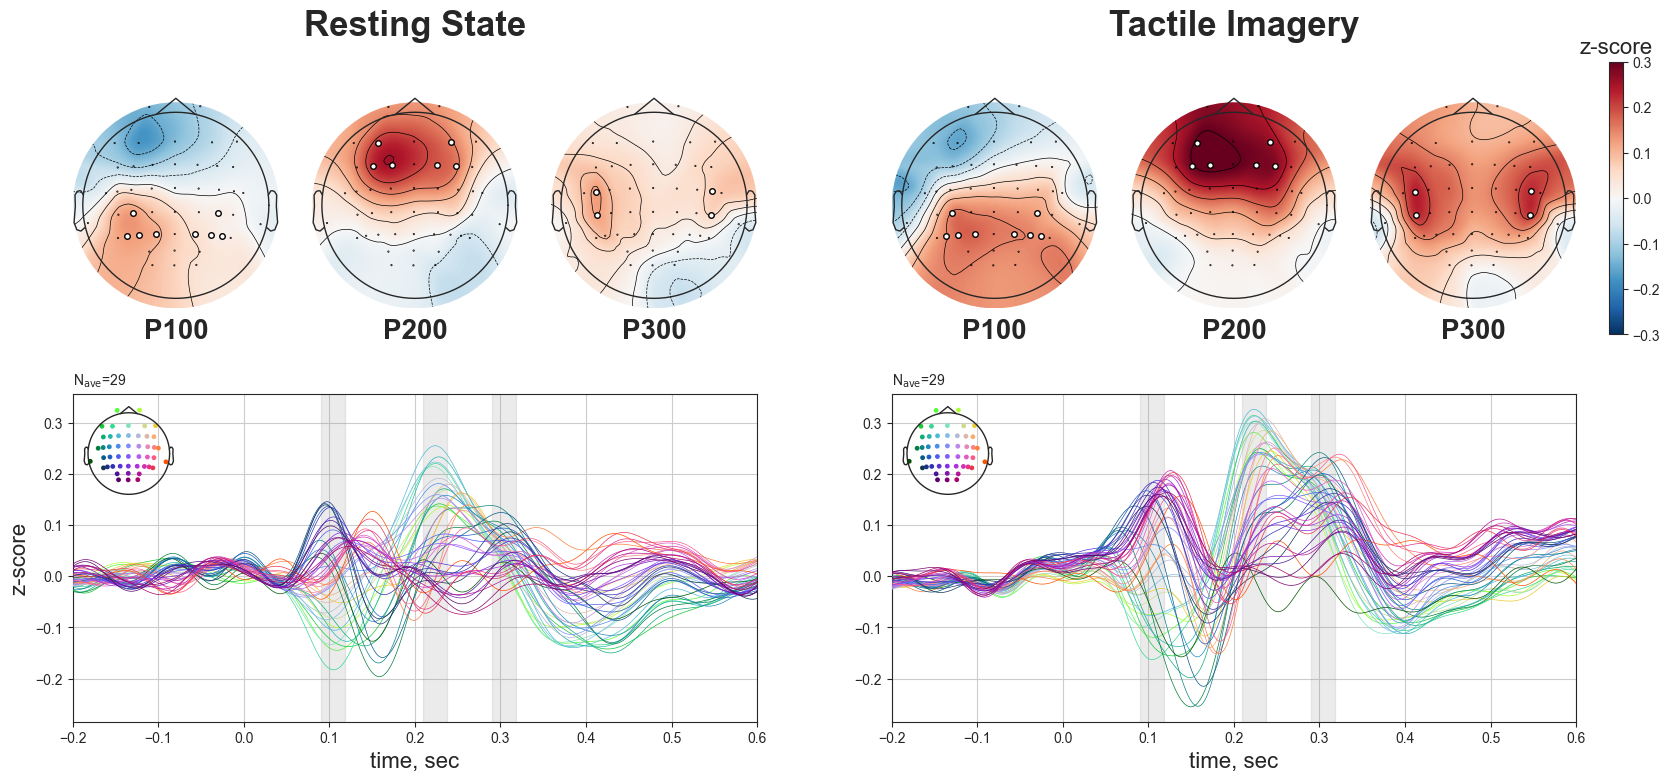

In [28]:
fig = plt.figure(dpi=100, figsize=(20, 8))
gs = GridSpec(nrows=2, ncols=8, figure=fig, width_ratios=[0.15]*3 + [0.05] + [0.15]*3 + [0.01], height_ratios=[0.5, 0.6])

locs = [
    es_p100_left+es_p100_right,
    es_p200_left+es_p200_right,
    es_p300_left+es_p300_right
]

for i, eps in enumerate([rest_erp, im_erp]):
    for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
        ax = fig.add_subplot(gs[0, i*3+j+1*i])
        im, cm = mne.viz.plot_topomap(np.mean(eps[:, :, times], axis=(0,-1)), info, axes=ax,
                                      vlim=(-0.3, 0.3), show=False, mask=np.array([True if e in locs[j] else False for e in range(len(electrodes))]))

        ax.set_xlabel(['P100', 'P200', 'P300'][j], fontsize=20, fontweight='bold')
        
        if (i, j) == (0, 1):
            ax.set_title('Resting State', fontsize=25, fontweight='bold', y=1.2)
            
        if (i, j) == (1, 1):
            ax.set_title('Tactile Imagery', fontsize=25, fontweight='bold', y=1.2)
        
ax = fig.add_subplot(gs[0, -1])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.set_title('z-score', fontsize=16)

axes = [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 4:-1])]

for i, eps in enumerate([rest_erp, im_erp]):
    
    eps_erp = mne.EpochsArray(eps/1e6, info, tmin=-0.5)
    eps_erp.average().plot(axes=axes[i], show=False)
    
    axes[i].grid()
    
    axes[i].set_xlim(-0.2, 0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title('')
    
for i in range(2):
    for j, times in enumerate([ts_p100, ts_p200, ts_p300]):
        axes[i].axvspan(eps_erp.times[times][0], eps_erp.times[times][-1], color='tab:gray', alpha=0.15)
    
axes[0].set_ylabel('z-score', fontsize=16)
axes[0].set_xlabel('time, sec', fontsize=16)
axes[1].set_xlabel('time, sec', fontsize=16)

axes[0].sharey(axes[1])

plt.savefig('figs/erps.jpg', bbox_inches='tight')
plt.show()

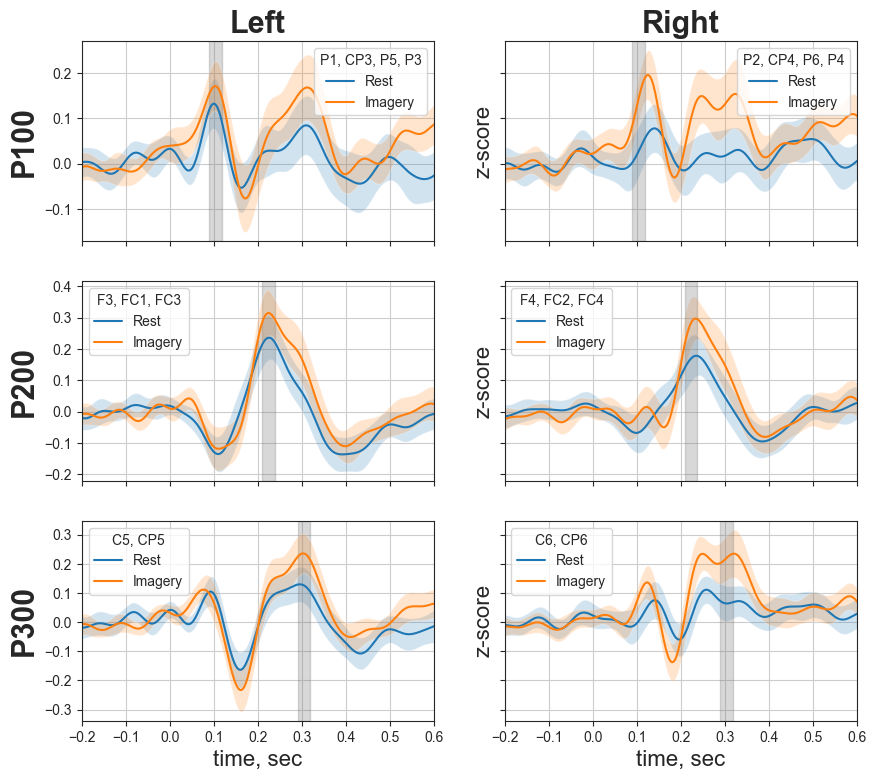

In [29]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9), dpi=100, sharey='row', sharex=True)

row_names = ['P100', 'P200', 'P300']
col_names = ['Left', 'Right']
times = [ts_p100, ts_p200, ts_p300]

for i in range(2):
    axes[0][i].set_title(col_names[i], fontsize=22, fontweight='bold')
    
for i in range(3):
    axes[i][0].set_ylabel(row_names[i], fontsize=22, fontweight='bold')
    axes[i][1].set_ylabel('z-score', fontsize=16)  

for i, locs in enumerate([[es_p100_left, es_p100_right], [es_p200_left, es_p200_right], [es_p300_left, es_p300_right]]):
    for j, data in enumerate([rest_erp, im_erp]):
        axes[i][0].plot(np.linspace(-0.5, 1, 751), data[:, locs[0]].mean(axis=(0, 1)), label=['Rest', 'Imagery'][j]) #'left: '+', '.join([electrodes[i] for i in locs[0]]))
        axes[i][1].plot(np.linspace(-0.5, 1, 751), data[:, locs[1]].mean(axis=(0, 1)), label=['Rest', 'Imagery'][j])
        
        ci = 1.96 * np.std(data[:, locs[0]].mean(axis=(1)), axis=0)/np.sqrt(len(data)) # confidence interval
        axes[i][0].fill_between(np.linspace(-0.5, 1, 751), (data[:, locs[0]].mean(axis=(0, 1))-ci), (data[:, locs[0]].mean(axis=(0, 1))+ci), alpha=.2)
        
        ci = 1.96 * np.std(data[:, locs[1]].mean(axis=(1)), axis=0)/np.sqrt(len(data)) # confidence interval
        axes[i][1].fill_between(np.linspace(-0.5, 1, 751), (data[:, locs[1]].mean(axis=(0, 1))-ci), (data[:, locs[1]].mean(axis=(0, 1))+ci), alpha=.2)
        
        axes[i][j].axvspan(eps_erp.times[times[i]][0], eps_erp.times[times[i]][-1], color='tab:gray', alpha=0.3)
        
        if i == 0:
            axes[i][0].legend(loc=1, title = ', '.join([electrodes[i] for i in locs[0]]))
            axes[i][1].legend(loc=1, title = ', '.join([electrodes[i] for i in locs[1]]))
        elif i in [1, 2]:
            axes[i][0].legend(loc=2, title = ', '.join([electrodes[i] for i in locs[0]]))
            axes[i][1].legend(loc=2, title = ', '.join([electrodes[i] for i in locs[1]]))
        axes[i][j].grid()
        axes[i][j].set_xlim(-0.2, 0.6)

axes[-1][0].set_xlabel('time, sec', fontsize=16)      
axes[-1][1].set_xlabel('time, sec', fontsize=16)   

plt.savefig('figs/chosen_electrodes_erp.jpg', bbox_inches='tight')
plt.show()

In [31]:
for t in range(250, 501, 5):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300)
    
    mne.viz.plot_topomap(np.mean(rest_erp[:, :, t-2:t+3], axis=(0,-1)), info, axes=axes[0], vlim=(-0.3, 0.3), show=False)
    mne.viz.plot_topomap(np.mean(im_erp[:, :, t-2:t+3], axis=(0,-1)), info, axes=axes[1], vlim=(-0.3, 0.3), show=False)
    
    axes[0].set_title('Rest', fontsize=16, fontweight='bold')
    axes[1].set_title('Imagery', fontsize=16, fontweight='bold')
    suptitle = plt.suptitle(str(np.round(t/500-0.5, 3))+' sec', fontsize=20)
    
    plt.savefig('for_gif/'+str(t)+'.png', bbox_extra_artists=[suptitle])
    
    plt.close()

In [30]:
import imageio

frames = []
for t in range(250, 501, 5):
    image = imageio.imread('for_gif/'+str(t)+'.png')
    frames.append(image)
    
imageio.mimsave('figs/rest_vs_imagery_erp.gif', # output gif
                frames,          # array of input frames
                fps = 3)  

In [32]:
def get_all_means(data_ppl, 
                  es_p100_left=es_p100_left, es_p100_right=es_p100_right, 
                  es_p200_left=es_p200_left, es_p200_right=es_p200_right,
                  es_p300_left=es_p300_left, es_p300_right=es_p300_right,
                  ts_p100=ts_p100, ts_p200=ts_p200, ts_p300=ts_p300):
    
    p100_left_data = data_ppl[:, es_p100_left, ts_p100].mean(axis=(-1, -2))
    p100_right_data = data_ppl[:, es_p100_right, ts_p100].mean(axis=(-1, -2))
    p200_left_data = data_ppl[:, es_p200_left, ts_p200].mean(axis=(-1, -2))
    p200_right_data = data_ppl[:, es_p200_right, ts_p200].mean(axis=(-1, -2))
    p300_left_data = data_ppl[:, es_p300_left, ts_p300].mean(axis=(-1, -2))
    p300_right_data = data_ppl[:, es_p300_right, ts_p300].mean(axis=(-1, -2))
    
    dict_ = {
        'P100_left': p100_left_data,
        'P100_right': p100_right_data,
        'P200_left': p200_left_data,
        'P200_right': p200_right_data,
        'P300_left': p300_left_data,
        'P300_right': p300_right_data
    }
    
    df = pd.DataFrame(dict_)
    return df

In [33]:
df_rest = get_all_means(rest_erp)
df_rest['condition'] = 'Rest'
df_rest['id'] = list(range(n_part))

df_im_im = get_all_means(im_erp)
df_im_im['condition'] = 'Imagery'
df_im_im['id'] = list(range(n_part))

df = pd.concat([df_rest, df_im_im])
df.head()

,P100_left,P100_right,P200_left,P200_right,P300_left,P300_right,condition,id
0,0.210086,-0.148431,-0.165474,-0.120714,0.375779,-0.139164,Rest,0
1,0.219220,-0.050457,0.146852,-0.019902,0.229345,0.041695,Rest,1
2,0.138060,0.160132,0.218078,0.101476,0.121188,0.278090,Rest,2
3,0.069452,0.037960,0.120836,0.114015,0.008327,0.055591,Rest,3
4,0.145690,0.042443,0.205903,0.189431,-0.087370,0.094832,Rest,4


In [34]:
for i in ['P100_left', 'P100_right', 'P200_left', 'P200_right', 'P300_left', 'P300_right']:
    for j in ['Rest', 'Imagery']:
        print(i, j)
        get_stat(df[df.condition == j][i])
        print()

P100_left Rest
0.14 [0.02-0.21]

P100_left Imagery
0.15 [0.04-0.27]

P100_right Rest
0.02 [-0.05-0.16]

P100_right Imagery
0.11 [0.07-0.17]

P200_left Rest
0.25 [0.12-0.30]

P200_left Imagery
0.35 [0.19-0.44]

P200_right Rest
0.15 [0.02-0.27]

P200_right Imagery
0.20 [0.14-0.43]

P300_left Rest
0.11 [0.04-0.22]

P300_left Imagery
0.21 [0.13-0.29]

P300_right Rest
0.06 [-0.06-0.15]

P300_right Imagery
0.19 [0.06-0.33]



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Rest v.s. Imagery: Wilcoxon test (paired samples), P_val=1.901e-01 stat=1.560e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Rest v.s. Imagery: Wilcoxon test (paired samples), P_val=5.506e-04 stat=6.500e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Rest v.s. Imagery: Wilcoxon test (paired samples), P_val=1.207e-01 stat=1.450e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  w

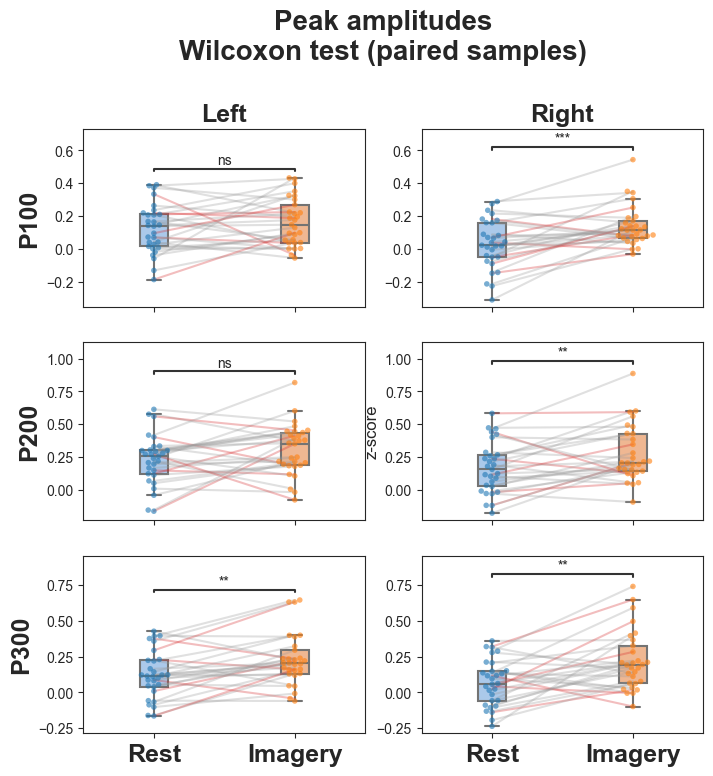

In [35]:
cond = np.array(list(np.argwhere(mu_power_learning>0)[0]) + list(np.argwhere(mu_power_imagery>0)[:, 0])) # bad_imaginers
not_cond = np.array([i for i in range(n_part) if i not in cond]) # good imaginers

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=100, figsize=(8, 8), sharex=True)
f1 = 18
f2 = 20

box_pairs = [
    ('Rest', 'Imagery')
]

peaks = [
    ['P100_left', 'P100_right'],
    ['P200_left', 'P200_right'],
    ['P300_left', 'P300_right']
]

palette = np.array(["#999999"]*len(np.unique(df.id)))
palette[cond.astype(int)] = '#D62728'

all_locs = [[es_p100_left, es_p100_right], [es_p200_left, es_p200_right], [es_p300_left, es_p300_right]]

for i, ps in enumerate(peaks):
    for j, peak in enumerate(ps):
        sns.boxplot(data=df, x='condition', y=peak, showfliers=False, ax=axes[i][j], palette='pastel', width=0.2)
        g = sns.swarmplot(data=df, x='condition', y=peak, ax=axes[i][j], alpha=0.6, size=4)
        sns.lineplot(data=df, y=peak, x='condition', hue='id', sort=False, palette=sns.color_palette(palette),
                     estimator=None, legend=False, ax=axes[i][j], alpha=0.3)
        
        test_results = add_stat_annotation(g, data=df, x='condition', y=peak,
                                           box_pairs=box_pairs, comparisons_correction=None,
                                           test='Wilcoxon', text_format='star',
                                           loc='inside', verbose=2)
        axes[i][j].set_xlabel('') 
        axes[i][j].set_ylabel('')
        
#         leg = axes[i][j].legend(loc=2)
#         leg.set_title(', '.join([electrodes[i] for i in all_locs[i][j]]),prop={'size':8})
    
    axes[i][0].set_ylabel(peak[:4], fontsize=f1, fontweight='bold')
    axes[i][0].sharey(axes[i][1])

    
axes[1][1].set_ylabel('z-score', fontsize=12)
    
axes[0][0].set_title('Left', fontsize=f1, fontweight='bold')
axes[0][1].set_title('Right', fontsize=f1, fontweight='bold')

axes[-1][0].set_xticklabels(['Rest', 'Imagery'], rotation=0, weight='bold', size=f1)
axes[-1][1].set_xticklabels(['Rest', 'Imagery'], rotation=0, weight='bold', size=f1)

suptitle = plt.suptitle('Peak amplitudes\nWilcoxon test (paired samples)', fontsize=f2, fontweight='bold', y=1.03)

plt.savefig('figs/erp_stats.jpg', bbox_extra_artists=[suptitle], bbox_inches='tight')

In [36]:
def get_li(x, y):
    return (x-y)/(x+y)

In [37]:
df_peaks_li = pd.DataFrame({
    'P100_rest':get_li(df[df.condition == 'Rest'].P100_right, df[df.condition == 'Rest'].P100_left),
    'P100_imagery':get_li(df[df.condition == 'Imagery'].P100_right, df[df.condition == 'Imagery'].P100_left),
    'P200_rest':get_li(df[df.condition == 'Rest'].P200_right, df[df.condition == 'Rest'].P200_left),
    'P200_imagery':get_li(df[df.condition == 'Imagery'].P200_right, df[df.condition == 'Imagery'].P200_left),
    'P300_rest':get_li(df[df.condition == 'Rest'].P300_right, df[df.condition == 'Rest'].P300_left),
    'P300_imagery':get_li(df[df.condition == 'Imagery'].P300_right, df[df.condition == 'Imagery'].P300_left),
})

df_peaks_li.head()

,P100_rest,P100_imagery,P200_rest,P200_imagery,P300_rest,P300_imagery
0,-5.814858,-1.328788,-0.156399,-0.265886,-2.176288,-0.864689
1,-1.597968,-0.377776,-1.313538,-0.402655,-0.692330,-1.079258
2,0.074018,0.349484,-0.364890,0.863674,0.392964,-0.004860
3,-0.293190,-1.149876,-0.029043,-0.088259,0.739444,0.124462
4,-0.548793,-0.476955,-0.041667,-0.651294,24.417617,-0.641514


In [38]:
for i in df_peaks_li.columns.values:
    print(i)
    get_stat(df_peaks_li[i])
    print()

P100_rest
-0.29 [-0.73-0.41]

P100_imagery
-0.07 [-0.38-0.45]

P200_rest
-0.13 [-0.32--0.02]

P200_imagery
-0.06 [-0.19-0.13]

P300_rest
-0.08 [-0.69-0.39]

P300_imagery
-0.00 [-0.49-0.18]



In [39]:
print(stats.wilcoxon(df_peaks_li.P100_rest, df_peaks_li.P100_imagery))
print(stats.wilcoxon(df_peaks_li.P200_rest, df_peaks_li.P200_imagery))
print(stats.wilcoxon(df_peaks_li.P300_rest, df_peaks_li.P300_imagery))

WilcoxonResult(statistic=136.0, pvalue=0.07975950092077255)
WilcoxonResult(statistic=135.0, pvalue=0.07598886638879776)
WilcoxonResult(statistic=209.0, pvalue=0.8647311441600323)
